In [64]:
#pip install -r requirements.txt
#pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu126

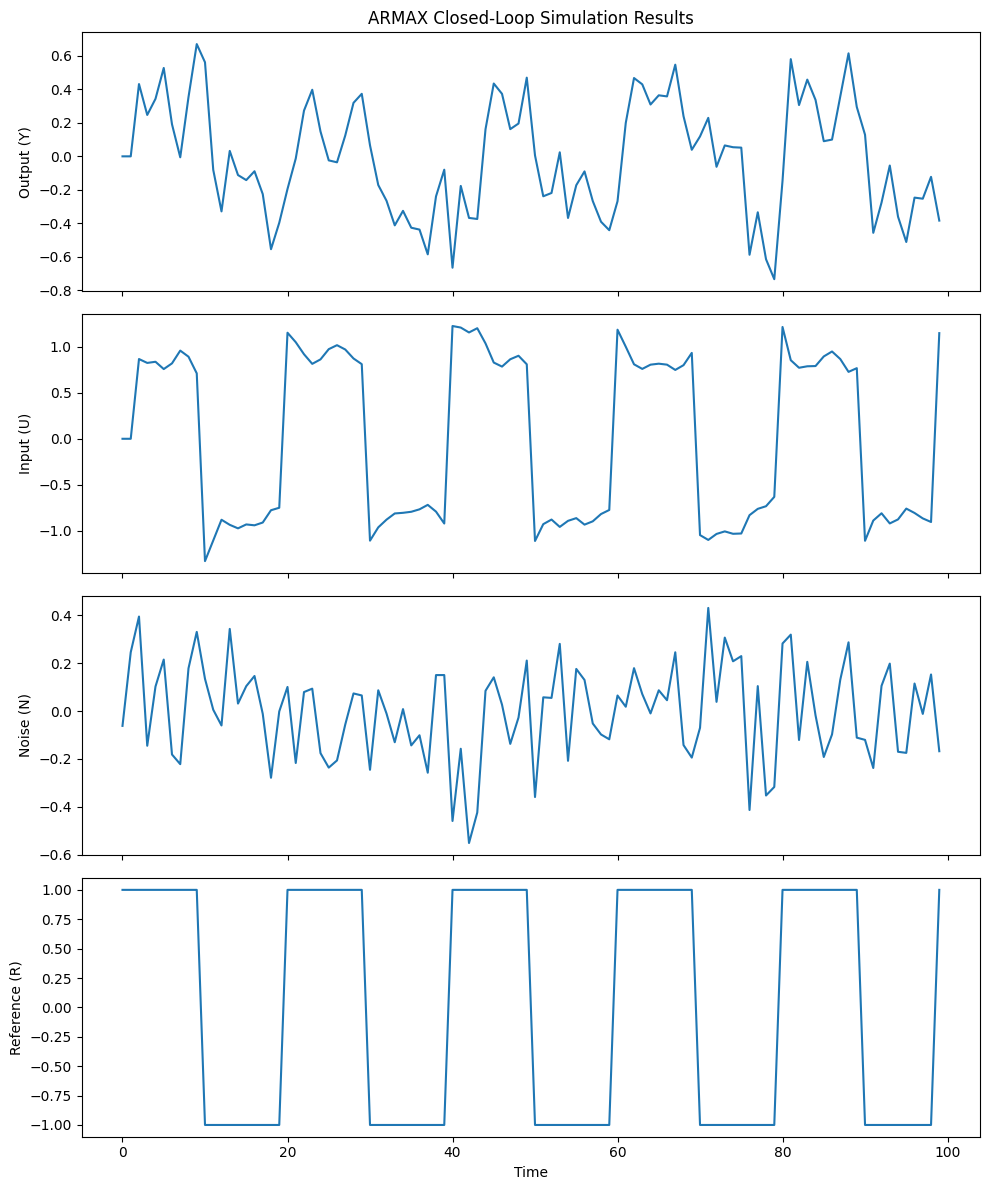

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

class ARMAX:
    def __init__(self, A, B, C, F, L):
        self.A = np.array(A)
        self.B = np.array(B)
        self.C = np.array(C)
        self.F = np.array(F)
        self.L = np.array(L)
    
    def simulate(self, n_samples, R=None, noise_std=0.1):
        Y = np.zeros(n_samples)
        U = np.zeros(n_samples)
        N = np.random.normal(0, noise_std, n_samples)
        
        if R is None:
            R = np.zeros(n_samples)
        
        max_order = max(len(self.A), len(self.B), len(self.C), len(self.F), len(self.L))
        
        for t in range(max_order, n_samples):
            Y[t] = (- np.dot(self.A[1:], Y[t-1:t-len(self.A):-1]) 
                    + np.dot(self.B, U[t-1:t-len(self.B)-1:-1])
                    + np.dot(self.C, N[t:t-len(self.C):-1]))
            
            U[t] = (np.dot(self.L, R[t:t-len(self.L):-1]) 
                    - np.dot(self.F, Y[t:t-len(self.F):-1]))
        
        return Y, U, N, R
    
    def plot_results(self, Y, U, N, R):
        fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
        
        axs[0].plot(Y)
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Closed-Loop Simulation Results')
        
        axs[1].plot(U)
        axs[1].set_ylabel('Input (U)')
        
        axs[2].plot(N)
        axs[2].set_ylabel('Noise (N)')
        
        axs[3].plot(R)
        axs[3].set_ylabel('Reference (R)')
        axs[3].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

# Example usage
A = [1, -0.33]  # A(z^-1) = 1 - 0.33z^-1
B = [0.22]      # B(z^-1) = 0.22z^-1
C = [1, 0.15]   # C(z^-1) = 1 + 0.15z^-1
F = [0.31, 0.23] # F(z^-1) = 0.31 + 0.23z^-1
L = [1]        # L(z^-1) = 1

armax_model = ARMAX(A, B, C, F, L)

n_samples = 100
# square wave reference signal
R = signal.square(np.linspace(0, 10*np.pi, n_samples))

Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)
armax_model.plot_results(Y, U, N, R)


In [72]:
import cupy as cp
from cupyx.scipy.signal import lfilter
cp.random.seed(42)
class d_tfs:
    def __init__(self, A):
        self.epsilon = cp.float64(1e-10)
        self.num = cp.asarray(A[0]).astype(self.epsilon.dtype)  # Ensure CuPy array
        self.den = cp.asarray(A[1]).astype(self.epsilon.dtype)   # Ensure CuPy array

    def __mul__(self, other):
        num = cp.convolve(self.num, other.num)  # Use cp.convolve for efficiency
        den = cp.convolve(self.den, other.den)
        return d_tfs((num, den))

    def add_scalar(self, scalar):
        # Multiply the denominator by the scalar
        scalar_denom = scalar * self.den
        # Ensure both polynomials have the same length by padding with zeros at the back
        if len(self.num) > len(scalar_denom):
            scalar_denom = cp.pad(scalar_denom, (0, len(self.num) - len(scalar_denom)))
        elif len(self.num) < len(scalar_denom):
            self.num = cp.pad(self.num, (0, len(scalar_denom) - len(self.num)))
        # Add the polynomials
        num_with_scalar = cp.polyadd(self.num, scalar_denom)
        return d_tfs((num_with_scalar, self.den))

    def __truediv__(self, other):
        num = cp.convolve(self.num, other.den)
        den = cp.convolve(self.den, other.num)
        return d_tfs((num, den))

    def __invert__(self):
        return d_tfs((self.den, self.num))

    def __str__(self):
        return f"Transfer Function: num={self.num}, den={self.den}"

    def __repr__(self):
        return self.__str__()

    def __call__(self, z):
        return cp.polyval(self.num, z) / cp.polyval(self.den, z)

    def apply_shift_operator(self, U_t):
        try:
            # Ensure input is a CuPy array
            U_t = cp.asarray(U_t)
            self.num += self.epsilon  # Add epsilon to avoid division by zero
            self.den += self.epsilon  # Add epsilon to avoid division by zero
            Y_t = lfilter(self.num, self.den, U_t)  # Use lfilter for filtering
            return cp.asarray(Y_t)
        except Exception as e:
            raise ValueError(f"Error applying shift operator: {e}")



def matrix_sqrt_gpu(A):
    try:
        A = cp.asarray(A)
        eigenvalues, eigenvectors = cp.linalg.eigh(A)
        sqrt_eigenvalues = cp.sqrt(cp.maximum(eigenvalues, 0))
        sqrt_matrix = eigenvectors @ cp.diag(sqrt_eigenvalues) @ eigenvectors.T
        return sqrt_matrix
    except Exception as e:
        raise ValueError(f"Error computing matrix square root: {e}")


class SPS_indirect_model:
    def __init__(self, m, q, T):
        self.m = m
        self.q = q
        self.T = T
        self.alpha = cp.random.choice([-1, 1], size=(m - 1, T))
        self.pi_order = cp.random.permutation(cp.arange(m))

    def transform_to_open_loop(self, G, H, F, L):
        G = d_tfs(G)
        H = d_tfs(H)
        F = d_tfs(F)
        L = d_tfs(L)

        GF_plus_I = (G * F).add_scalar(1)
        i_GF_plus_I = ~GF_plus_I
        G_0 = i_GF_plus_I * G * L
        H_0 = i_GF_plus_I * H
        return G_0, H_0

    def open_loop_sps(self, G_0, H_0, Y_t, U_t, n_a, n_b):
        try:
            Y_t = cp.asarray(Y_t)
            U_t = cp.asarray(U_t)
            YGU = Y_t - G_0.apply_shift_operator(U_t)
            N_hat = (~H_0).apply_shift_operator(YGU)
            perturbed_N_hat = self.alpha * N_hat 
            y_bar = [
                G_0.apply_shift_operator(U_t) + H_0.apply_shift_operator(perturbed_N_hat[i])
                for i in range(self.m - 1)
            ]

            y_bar = cp.array(y_bar)
            W = d_tfs(([0] + [-1] * n_a, [1]))
            Q = d_tfs(([0] + [1] * n_b, [1]))
            phi_bar = W.apply_shift_operator(y_bar) + Q.apply_shift_operator(U_t)
            phi = W.apply_shift_operator(Y_t) + Q.apply_shift_operator(U_t)
            phi_tilde = cp.vstack((phi, phi_bar))

            S = cp.zeros(self.m)
            for i in range(self.m):
                R_i = cp.einsum('i,j->ij', phi_tilde[i], phi_tilde[i]) / len(Y_t)
                R_root_inv = cp.linalg.pinv(matrix_sqrt_gpu(R_i))
                N_hat_i = N_hat if i == 0 else perturbed_N_hat[i - 1]
                weighted_sum = cp.sum(N_hat_i * phi_tilde[i])
                S[i] = cp.linalg.norm(R_root_inv * weighted_sum, ord=2)

            combined = cp.array(list(zip(self.pi_order, S)))
            order= cp.lexsort(combined.T)
            rank_R = cp.where(order == 0)[0][0] + 1
            return rank_R <= self.m - self.q
        except Exception as e:
            raise ValueError(f"Error in open-loop SPS: {e}")

# Example usage with CuPy:
A  = [1, -0.33]
B = [0, 0.22]
C = [1, 0.15]

G = (B, A)  
H = (C, A)     
F = ([0.31, 0.23], [1])  
L = ([1], [1])         

m = 100
q = 5
T = n_samples  # Example sample size

import cProfile, pstats
profiler = cProfile.Profile()
profiler.enable()

model = SPS_indirect_model(m, q, T)
G_0, H_0 = model.transform_to_open_loop(G, H, F, L)
model.open_loop_sps(G_0, H_0, Y, U, 1, 1)

profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()

         76821 function calls (76818 primitive calls) in 7.085 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    7.085    1.771 {built-in method builtins.exec}
        1    0.057    0.057    7.070    7.070 C:\Users\mukul\AppData\Local\Temp\ipykernel_13068\1161291878.py:88(open_loop_sps)
      200    0.008    0.000    6.035    0.030 d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\cupy\linalg\_decomposition.py:463(svd)
      200    5.983    0.030    5.983    0.030 {built-in method cupy_backends.cuda.libs.cusolver.dgesvd}
      100    0.088    0.001    4.160    0.042 d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\cupy\linalg\_solve.py:327(pinv)
      100    0.002    0.000    2.056    0.021 d:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\.venv\Lib\site-packages\cupy\linalg\_norms.py:31(norm)
 

In [67]:
import torch
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np

C = cp.array([1, 0.15])         # C(z^-1) = 1 + 0.15z^-1
F = (cp.array([0.31, 0.23]), cp.array([1]))  # F(z^-1) = 0.31 + 0.23z^-1
L = (cp.array([1]), cp.array([1]))         # L(z^-1) = 1

m = 100
q = 5
T = n_samples
model = SPS_indirect_model(m, q, T)

# Create arrays for a and b values
a_values = cp.arange(0.3, 0.5, 0.1)
b_values = cp.arange(-0.1, 0.5, 0.5)

# Create a meshgrid for a and b values
a_grid, b_grid = cp.meshgrid(a_values, b_values, indexing='ij')

# Flatten the grids for iteration
a_flat = a_grid.ravel()
b_flat = b_grid.ravel()

# Store results in a list
results = []

# Create torch tensors directly on GPU
a_torch = torch.tensor(a_flat, dtype=torch.float32, device='cuda')
b_torch = torch.tensor(b_flat, dtype=torch.float32, device='cuda')

# Vectorized operations to minimize Python loops
A_torch = torch.stack([torch.ones_like(a_torch), -a_torch], dim=-1)
B_torch = torch.stack([torch.zeros_like(b_torch), b_torch], dim=-1)

# Perform the operations in batch
A = cp.from_dlpack(A_torch)
B = cp.from_dlpack(B_torch)

# Assuming 'model' is predefined and contains the necessary methods
for i in range(len(a_flat)):
    G = (B[i], A[i])  # G should be a tuple of arrays
    H = (C, A[i])  # H should be a tuple of arrays

    # Transform to open loop
    G_0, H_0 = model.transform_to_open_loop(G, H, F, L)  # Assuming F and L are defined

    # Check the condition and store the result if true
    if model.open_loop_sps(G_0, H_0, Y, U, 1, 1):  # Assuming Y and U are defined
        results.append((a_flat[i].item(), b_flat[i].item()))

# Convert the results to a NumPy array
results = np.array(results)
# Plot the results
fig, ax = plt.subplots()
ax.plot(results[:, 0], results[:, 1], 'bo')  # Plot the points as blue dots

# Labeling the plot
ax.set_xlabel('a')
ax.set_ylabel('b')
# axis limits
ax.set_xlim([0.3, 0.5])
ax.set_ylim([-0.1, 0.5])
ax.set_title('Points for which open_loop_sps returns True')

# Plot the true values
ax.plot(0.33, 0.22, 'ro')  # Plot the true values as a red dot

# Show the plot
plt.show()


KeyboardInterrupt: 

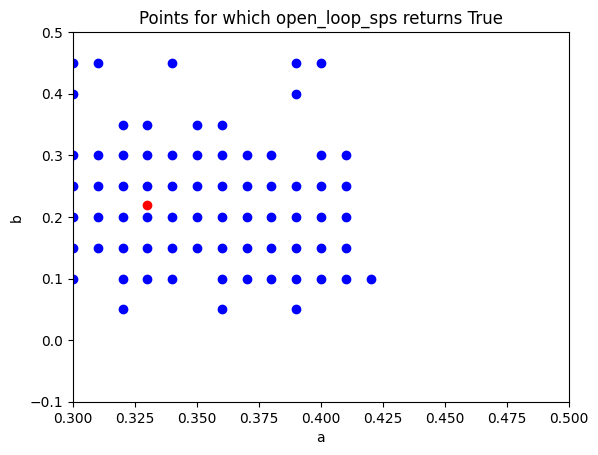

In [69]:

# Convert the results to a NumPy array
results = np.array(results)
# Plot the results
fig, ax = plt.subplots()
ax.plot(results[:, 0], results[:, 1], 'bo')  # Plot the points as blue dots

# Labeling the plot
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_title('Points for which open_loop_sps returns True')
ax.set_xlim([0.3, 0.5])
ax.set_ylim([-0.1, 0.5])
# Plot the true values
ax.plot(0.33, 0.22, 'ro')  # Plot the true values as a red dot

# Show the plot
plt.show()